# LLM Classification Finetuning

이 대회는 Human Preference Prediction 문제입니다.

사람이 두 모델 중 어느 답변이 더 좋다고 판단한 데이터를 기반으로,

새로운 쌍이 주어졌을 때 그 선택을 예측하는 모델을 만드는 것이 목표입니다.

Reward Model / Preference Model을 만드는 것이 목표입니다.

## 모듈 임포트

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import ttest_ind, chi2_contingency
import statsmodels.api as sm

In [2]:
import statsmodels.formula.api as smf

In [3]:
from scipy.stats import shapiro, levene
from scipy.stats import kruskal
import nltk
from textblob import TextBlob

In [4]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [5]:
import re

def get_features(df):
    df['len_a'] = df['response_a'].str.len()
    df['len_b'] = df['response_b'].str.len()
    df['word_count_a'] = df['response_a'].apply(lambda x: len(str(x).split()))
    df['word_count_b'] = df['response_b'].apply(lambda x: len(str(x).split()))
    df['punc_count_a'] = df['response_a'].apply(lambda x: len(re.findall(r'[!?,;:]', str(x))))
    df['punc_count_b'] = df['response_b'].apply(lambda x: len(re.findall(r'[!?,;:]', str(x))))
    df['len_diff'] = df['len_a'] - df['len_b']
    df['word_diff'] = df['word_count_a'] - df['word_count_b']
    df['punc_diff'] = df['punc_count_a'] - df['punc_count_b']
    return df

train_df = get_features(train_df)
test_df = get_features(test_df)

## EDA & Statistical Analysis

In [6]:
model_a_wins = train_df['winner_model_a'].sum()
model_b_wins = train_df['winner_model_b'].sum()
ties = train_df['winner_tie'].sum()

Train shape: (57477, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
 9   len_a           57477 non-null  int64 
 10  len_b           57477 non-null  int64 
 11  word_count_a    57477 non-null  int64 
 12  word_count_b    57477 non-null  int64 
 13  punc_count_a    57477 non-null  int64 
 14  punc_count_b    57477 non-null  int64 
 15  len_diff        57477 non-null  int64 
 16  word_diff       57477 non-null  int64 
 17  punc_diff       57477 non

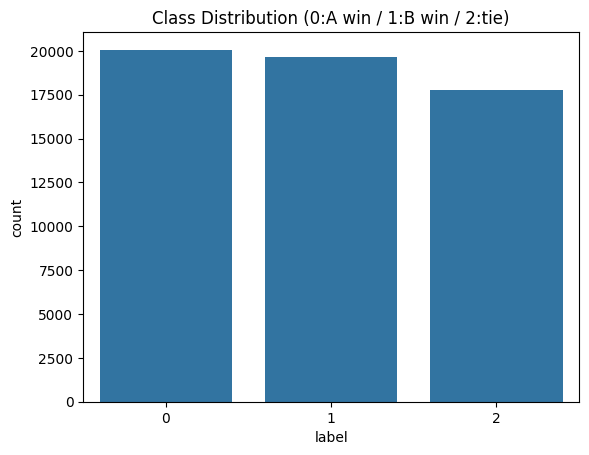

In [7]:
print("Train shape:", train_df.shape)
print(train_df.info())

train_df['label'] = np.select(
    [train_df['winner_model_a']==1, train_df['winner_model_b']==1, train_df['winner_tie']==1],
    [0,1,2]
)
sns.countplot(x=train_df['label'])
plt.title("Class Distribution (0:A win / 1:B win / 2:tie)")
plt.show()

In [8]:
desc = train_df[['len_a','len_b','word_count_a','word_count_b','punc_count_a','punc_count_b']].describe().T
print(desc)

                count         mean          std  min    25%     50%     75%  \
len_a         57477.0  1377.818919  1513.932333  4.0  408.0  1076.0  1862.0   
len_b         57477.0  1386.162169  1537.800488  4.0  413.0  1086.0  1873.0   
word_count_a  57477.0   204.371070   218.697891  1.0   64.0   162.0   279.0   
word_count_b  57477.0   205.177254   220.905999  1.0   65.0   163.0   280.0   
punc_count_a  57477.0    17.180229    22.739515  0.0    4.0    11.0    23.0   
punc_count_b  57477.0    17.273605    21.940932  0.0    4.0    11.0    23.0   

                  max  
len_a         54058.0  
len_b         53830.0  
word_count_a   9021.0  
word_count_b   7886.0  
punc_count_a   1357.0  
punc_count_b    840.0  


### H1. Verbosity bias: 단순 내용이 많으면 더 낫다고 느낀다.

In [9]:
train_df['len_diff'] = train_df['len_a'] - train_df['len_b']

/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_82852/551550295.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


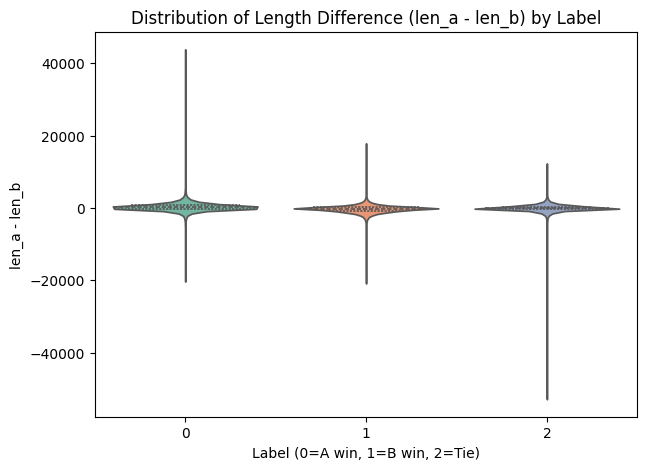

In [10]:
plt.figure(figsize=(7,5))
sns.violinplot(
    data=train_df,
    x='label', y='len_diff',
    palette='Set2',
    inner='quartile'
)
plt.title("Distribution of Length Difference (len_a - len_b) by Label")
plt.xlabel("Label (0=A win, 1=B win, 2=Tie)")
plt.ylabel("len_a - len_b")
plt.show()

In [11]:
a_win = train_df[train_df['label'] == 0]['len_diff']
b_win = train_df[train_df['label'] == 1]['len_diff']

# 독립표본 t-검정 (Welch’s t-test)
t_stat, p_value = ttest_ind(a_win, b_win, equal_var=False)

print(f"T-test result: t={t_stat:.3f}, p={p_value:.5f}")

# 각 그룹의 평균 비교
mean_a = a_win.mean()
mean_b = b_win.mean()

print(f"Mean len_diff (A win): {mean_a:.2f}")
print(f"Mean len_diff (B win): {mean_b:.2f}")

T-test result: t=47.126, p=0.00000
Mean len_diff (A win): 253.49
Mean len_diff (B win): -277.85


In [12]:
model = smf.ols("label ~ len_diff + C(model_a) + C(model_b)", data=train_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     16.21
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:52:43   Log-Likelihood:                -68448.
No. Observations:               57477   AIC:                         1.372e+05
Df Residuals:                   57349   BIC:                         1.383e+05
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

모델명을 통제한 상태에서도 더 긴 응답을 제공할수록 인간이 선택할 확률이 높아진다는 것 확인

### H2. 구두점이 많으면 선택될 확률이 높다.

label
0    3.558214
1   -3.708427
2   -0.218512
Name: punc_diff, dtype: float64


/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_82852/1584650988.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='punc_diff', data=train_df, palette='pastel')


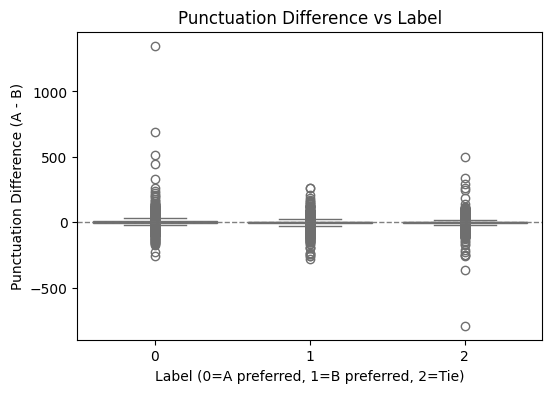

In [13]:
# label별 평균
summary = train_df.groupby('label')['punc_diff'].mean()
print(summary)

# 시각화
plt.figure(figsize=(6,4))
sns.boxplot(x='label', y='punc_diff', data=train_df, palette='pastel')
plt.title("Punctuation Difference vs Label")
plt.xlabel("Label (0=A preferred, 1=B preferred, 2=Tie)")
plt.ylabel("Punctuation Difference (A - B)")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

In [14]:
#통계적 검증은 어떨까?
# Shapiro-Wilk 정규성 검정 (각 label 그룹별)
for label in train_df['label'].unique():
    stat, p = shapiro(train_df.loc[train_df['label']==label, 'punc_diff'])
    print(f"Label {label} → p-value: {p:.4f}")

# 등분산성 (Levene 검정)
stat, p = levene(
    train_df.loc[train_df['label']==0, 'punc_diff'],
    train_df.loc[train_df['label']==1, 'punc_diff'],
    train_df.loc[train_df['label']==2, 'punc_diff']
)
print(f"Levene’s test p-value: {p:.4f}")


Label 0 → p-value: 0.0000
Label 1 → p-value: 0.0000
Label 2 → p-value: 0.0000
Levene’s test p-value: 0.0000


/Users/youjunglee/Proj2/proj2/.venv/lib/python3.14/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20064.
  res = hypotest_fun_out(*samples, **kwds)
/Users/youjunglee/Proj2/proj2/.venv/lib/python3.14/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 19652.
  res = hypotest_fun_out(*samples, **kwds)
/Users/youjunglee/Proj2/proj2/.venv/lib/python3.14/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17761.
  res = hypotest_fun_out(*samples, **kwds)


punc_diff의 값은 정규분포를 따르지 않으며, 세 라벨의 분산은 서로 다르다.

In [15]:
kw_stat, kw_p = kruskal(
    train_df.loc[train_df['label']==0, 'punc_diff'],
    train_df.loc[train_df['label']==1, 'punc_diff'],
    train_df.loc[train_df['label']==2, 'punc_diff']
)
print(f"Kruskal-Wallis test statistic: {kw_stat:.4f}, p-value: {kw_p:.6f}")

Kruskal-Wallis test statistic: 2627.1266, p-value: 0.000000


즉, 사람이 선택하는 모델에 구두점 사용량의 차이를 수반한다.
구두점이 많은 응답을 더 선호하는 경향이 존재한다.

- For label 0 (Model A preferred), the median punc_diff is positive, indicating that Model A’s responses typically include more punctuation marks.
- Conversely, for label 1 (Model B preferred), the median shifts below zero, suggesting that the response with richer punctuation is generally the one selected by annotators.
- The tie cases (label 2) cluster around zero, implying that humans tend to perceive two responses as equivalent when their punctuation usage is similar.

### H3. (언어적 복잡성) 문장이 얼마나 다양한 단어와 품사를 쓰는지가 영향을 미친다.

풍부한 어휘를 포함하고, 길고 복잡하며, 수식어가 많은 문장일수록 좋게 평가한다.

In [16]:
# 처음 한 번만 실행
nltk.download('punkt')

def simple_linguistic_features(text):
    text = str(text)
    words = re.findall(r'\b\w+\b', text.lower())         # 단어 리스트
    unique_words = set(words)
    
    # 어휘 다양성
    lexical_diversity = len(unique_words) / (len(words) + 1e-9)
    
    # 평균 단어 길이
    avg_word_len = np.mean([len(w) for w in words]) if words else 0
    
    # 문장 수
    sentence_count = len(re.findall(r'[.!?]', text))
    
    # 쉼표, 세미콜론 비율
    comma_semicolon_ratio = len(re.findall(r'[;,]', text)) / (len(words) + 1e-9)
    
    # 감정 점수 / 주관성 (TextBlob)
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity      # -1(부정) ~ +1(긍정)
    subjectivity = blob.sentiment.subjectivity  # 0(객관) ~ 1(주관)
    
    # 중복 단어 비율
    repetition_ratio = 1 - (len(unique_words) / (len(words) + 1e-9))
    
    return lexical_diversity, avg_word_len, sentence_count, comma_semicolon_ratio, sentiment, subjectivity, repetition_ratio


cols = ['lexical_div', 'avg_word_len', 'sent_count', 'comma_ratio', 
        'sentiment', 'subjectivity', 'repetition']

for side in ['a', 'b']:
    train_df[[f'{c}_{side}' for c in cols]] = train_df[f'response_{side}'].apply(
        lambda x: pd.Series(simple_linguistic_features(x))
    )

# 차이 피처 생성
for c in cols:
    train_df[f'{c}_diff'] = train_df[f'{c}_a'] - train_df[f'{c}_b']


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/youjunglee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
feature_cols = [f"{c}_diff" for c in cols]
p_values = {}

for f in feature_cols:
    kw_stat, p = kruskal(
        train_df.loc[train_df['label']==0, f],
        train_df.loc[train_df['label']==1, f],
        train_df.loc[train_df['label']==2, f]
    )
    p_values[f] = p

sorted_p = sorted(p_values.items(), key=lambda x: x[1])
pd.DataFrame(sorted_p, columns=['Feature','p-value'])

,Feature,p-value
0,sent_count_diff,0.000000e+00
1,lexical_div_diff,8.496740e-226
2,repetition_diff,8.496740e-226
3,subjectivity_diff,1.032692e-05
4,comma_ratio_diff,6.992539e-04
5,avg_word_len_diff,3.865051e-02
6,sentiment_diff,7.820750e-01


- sent_count_diff: 문장 수 차이 영향을 미친다. (punc와 유사)
- lexical_div_diff: 어휘 다양성 차이가 강하게 영향이 있다
- repetition_diff: 단어 반복률에서 중복이 적고, 다양한 언어를 표현한 쪽이 선택받을 확률이 높다
- subjectivity_diff: TextBlob을 통한 주관/객관 평가 결과 주관적 어조가 높은 쪽이 선택받을 확률이 높다.
- comma_ratio_diff: 쉼표나 세미콜론 사용이 많은 쪽이 약간 더 선호된다.
하지만, 한 단어의 평균 길이나 긍/부정은 유의하지 않은 영향을 주었다.

### H4. 많이 사용되는 특정 단어가 모델의 승률에 영향을 미친다.

/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_82852/544931525.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


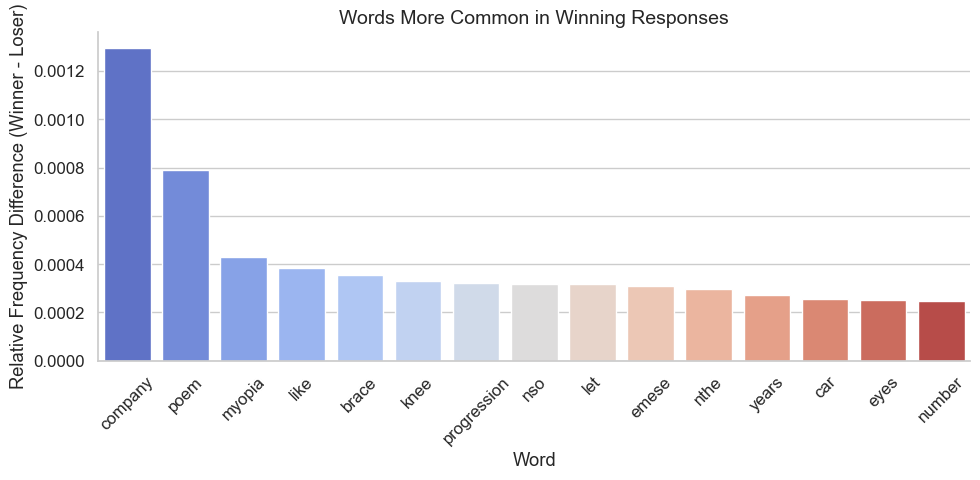

,word,winner_freq,loser_freq,diff
146,company,0.002753,0.001456,0.001297
659,poem,0.001141,0.000353,0.000788
561,myopia,0.000767,0.000336,0.000432
489,like,0.007700,0.007317,0.000383
91,brace,0.000573,0.000218,0.000355
459,knee,0.000565,0.000233,0.000332
704,progression,0.000670,0.000347,0.000323
598,nso,0.001694,0.001375,0.000318
481,let,0.003398,0.003079,0.000318
267,emese,0.000574,0.000266,0.000308


In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# 1️⃣ 실제 승자/패자 텍스트 구분
winner_texts = []
loser_texts = []

for _, row in train_df.iterrows():
    if row['winner_model_a'] == 1:
        winner_texts.append(row['response_a'])
        loser_texts.append(row['response_b'])
    elif row['winner_model_b'] == 1:
        winner_texts.append(row['response_b'])
        loser_texts.append(row['response_a'])
    elif row['winner_tie'] == 1:
        # tie일 때는 둘 다 승자처럼 간주 (가중치 반영 안 함)
        winner_texts.append(row['response_a'])
        winner_texts.append(row['response_b'])

# 2️⃣ CountVectorizer (공통 vocab으로 학습)
vectorizer = CountVectorizer(stop_words='english',
                             token_pattern=r'\b[a-zA-Z]{3,}\b',
                             max_features=1000)

vectorizer.fit(winner_texts + loser_texts)

winner_counts = vectorizer.transform(winner_texts).toarray().sum(axis=0)
loser_counts = vectorizer.transform(loser_texts).toarray().sum(axis=0)

words = vectorizer.get_feature_names_out()

# 3️⃣ 상대 빈도(normalized frequency)
freq_df = pd.DataFrame({
    'word': words,
    'winner_freq': winner_counts / winner_counts.sum(),
    'loser_freq': loser_counts / loser_counts.sum()
})

freq_df['diff'] = freq_df['winner_freq'] - freq_df['loser_freq']
freq_df = freq_df.sort_values('diff', ascending=False)

# 4️⃣ 시각화 (상위 단어 15개)
plt.figure(figsize=(10, 5))
sns.barplot(
    data=freq_df.head(15),
    x='word', y='diff',
    palette='coolwarm'
)
plt.title("Words More Common in Winning Responses", fontsize=14)
plt.xlabel("Word")
plt.ylabel("Relative Frequency Difference (Winner - Loser)")
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.show()

freq_df.head(10)


In [24]:
from scipy.stats import chi2_contingency
import numpy as np

chi_results = []

total_winner_words = winner_counts.sum()
total_loser_words = loser_counts.sum()

for word, w_count, l_count in zip(words, winner_counts, loser_counts):
    # 2x2 contingency table
    table = np.array([
        [w_count, total_winner_words - w_count],
        [l_count, total_loser_words - l_count]
    ])
    chi2, p, dof, exp = chi2_contingency(table, correction=False)
    chi_results.append((word, p, w_count, l_count))

chi_df = pd.DataFrame(chi_results, columns=['word', 'p_value', 'winner_count', 'loser_count'])
chi_df = chi_df.sort_values('p_value')

chi_df.head(10)


,word,p_value,winner_count,loser_count
937,ufffd,0.000000e+00,1182,2913
146,company,2.100971e-206,10814,2817
659,poem,7.444203e-201,4482,683
561,myopia,4.953642e-86,3015,650
91,brace,3.661066e-80,2251,421
459,knee,2.674672e-70,2221,451
267,emese,1.339203e-58,2256,515
704,progression,3.088687e-54,2632,671
40,apologize,2.510399e-37,1990,1510
840,sorry,5.074453e-35,2245,1646


(uffffd is encoding error)

하지만 Chi-squared test가 통계적으로 유의하더라도,
각 row가 동일한 prompt, instruction을 공유하기 때문에
샘플의 독립성을 깨뜨림. 따라서, 올바른 접근 방법은 아님.

그렇다면, prompt별 편차를 random effect로 잡아 독립성 가정 문제를 해결하자!

In [28]:
# tie 포함한 기존 label 사용 (0=A승, 1=B승, 2=tie)
# → tie는 중립값처럼 포함 가능 or 제외할지 선택 가능

df = train_df.copy().reset_index(drop=True)
df['id'] = df['id'].astype(int)

# 예시 단어: poem
df['poem_in_a'] = df['response_a'].str.contains(r'\bpoem\b', case=False, na=False).astype(int)
df['poem_in_b'] = df['response_b'].str.contains(r'\bpoem\b', case=False, na=False).astype(int)

# 두 응답 간 단어 포함 차이 (A=1, B=-1, 둘 다=0)
df['poem_diff'] = df['poem_in_a'] - df['poem_in_b']

# tie(2)를 중립값으로 변환 (로짓 회귀 위해)
df['label_bin'] = df['label'].replace({0: 1, 1: 0, 2: 0.5})

# mixed-effects logistic regression
model = smf.mixedlm(
    "label_bin ~ poem_diff",
    data=df,
    groups=df["id"]
)
result = model.fit(reml=False, method="lbfgs")
print(result.summary())


/Users/youjunglee/Proj2/proj2/.venv/lib/python3.14/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: label_bin  
No. Observations: 57477   Method:             ML         
No. Groups:       57477   Scale:              0.0864     
Min. group size:  1       Log-Likelihood:     -31091.3817
Max. group size:  1       Converged:          Yes        
Mean group size:  1.0                                    
---------------------------------------------------------
              Coef. Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept     0.504    0.000 2496.273 0.000  0.503  0.504
poem_diff     0.012    0.021    0.566 0.572 -0.030  0.054
Group Var     0.086                                      



Chi-squared에서는 poem이 많은 쪽이 더 선택 확률이 높다고 했으나, 해당 검정 기법으로는 기각됨.

In [29]:
# 단어 리스트
target_words = ['company', 'poem', 'myopia', 'brace', 'knee', 
                'emese', 'progression', 'apologize', 'sorry']

df = train_df.copy().reset_index(drop=True)
df['id'] = df['id'].astype(int)

# tie(2)를 0.5로 유지
df['label_bin'] = df['label'].replace({0:1, 1:0, 2:0.5})

# 각 단어별 diff feature 생성
for w in target_words:
    df[f'{w}_in_a'] = df['response_a'].str.contains(fr'\b{w}\b', case=False, na=False).astype(int)
    df[f'{w}_in_b'] = df['response_b'].str.contains(fr'\b{w}\b', case=False, na=False).astype(int)
    df[f'{w}_diff'] = df[f'{w}_in_a'] - df[f'{w}_in_b']

# formula 자동 생성
feature_terms = ' + '.join([f'{w}_diff' for w in target_words])
formula = f"label_bin ~ {feature_terms}"

# mixed-effects linear model
model = smf.mixedlm(formula, data=df, groups=df["id"])
result = model.fit(reml=False, method="lbfgs")

print(result.summary())


/Users/youjunglee/Proj2/proj2/.venv/lib/python3.14/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  label_bin  
No. Observations:   57477    Method:              ML         
No. Groups:         57477    Scale:               0.0852     
Min. group size:    1        Log-Likelihood:      -30687.3088
Max. group size:    1        Converged:           Yes        
Mean group size:    1.0                                      
-------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept         0.503    0.000 4021.637 0.000  0.503  0.504
company_diff      0.035    0.010    3.463 0.001  0.015  0.055
poem_diff         0.015    0.021    0.704 0.482 -0.027  0.056
myopia_diff       0.132    0.125    1.055 0.291 -0.113  0.377
brace_diff        0.139    0.059    2.363 0.018  0.024  0.255
knee_diff         0.128    0.046    2.798 0.005  0.038  0.218
emese_diff       -0.

검정 결과
- Company, Brace, Knee, Progression이 들어간 경우 승률이 높음
- Apologize, Sorry가 들어간 경우 승률이 낮음

하지만 prompt 별 차이가 명확히 존재하므로, 질문의 영향이 존재함.
질문 및 대답을 보고, 해당 단어가 들어가는 row에 한해서만 변수를 유의하게 조작할 필요 있음

In [30]:
train_df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,len_a,...,avg_word_len_diff,sent_count_diff,comma_ratio_diff,sentiment_diff,subjectivity_diff,repetition_diff,poem_in_a,poem_in_b,winner_label,poem_diff
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,4538,...,0.579747,27.0,-0.023723,-0.042028,0.006711,0.096081,0,0,1.0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,3114,...,-0.296644,-16.0,-0.009354,-0.094216,-0.018551,0.124652,0,0,0.0,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,921,...,-0.117240,-6.0,-0.030998,0.192857,0.374405,-0.142640,0,0,NaN,0
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,3182,...,0.023483,11.0,0.015884,-0.069785,0.026196,0.103679,0,0,1.0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0,1300,...,-0.411654,2.0,0.004887,-0.048932,0.054701,0.123966,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0,396,...,-0.514282,9.0,0.057855,0.302778,0.188889,-0.183474,0,0,1.0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0,1707,...,0.071874,-11.0,0.010044,-0.515909,-0.009512,-0.041789,0,0,1.0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0,8683,...,0.419388,91.0,-0.020066,-0.138133,-0.285929,0.069617,0,0,1.0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0,435,...,0.119532,-6.0,0.014035,0.109833,-0.087333,-0.001637,0,0,0.0,0


## 모델 별 비교

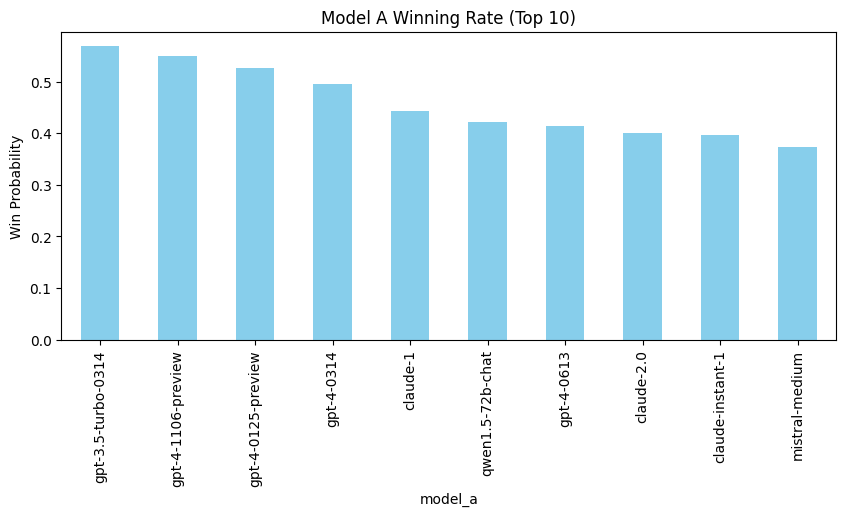

In [19]:
# 각 모델의 평균 승률
model_a_winrate = train_df.groupby('model_a')['winner_model_a'].mean()
model_b_winrate = train_df.groupby('model_b')['winner_model_b'].mean()

top_a = model_a_winrate.sort_values(ascending=False).head(10)
top_b = model_b_winrate.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,4))
top_a.plot(kind='bar', color='skyblue')
plt.title("Model A Winning Rate (Top 10)")
plt.ylabel("Win Probability")
plt.show()


In [20]:
# 카이제곱 검정 (model과 승패의 관계)
table = pd.crosstab(train_df['model_a'], train_df['winner_model_a'])
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi-square: {chi2:.2f}, p-value: {p:.5f}")

Chi-square: 2158.22, p-value: 0.00000


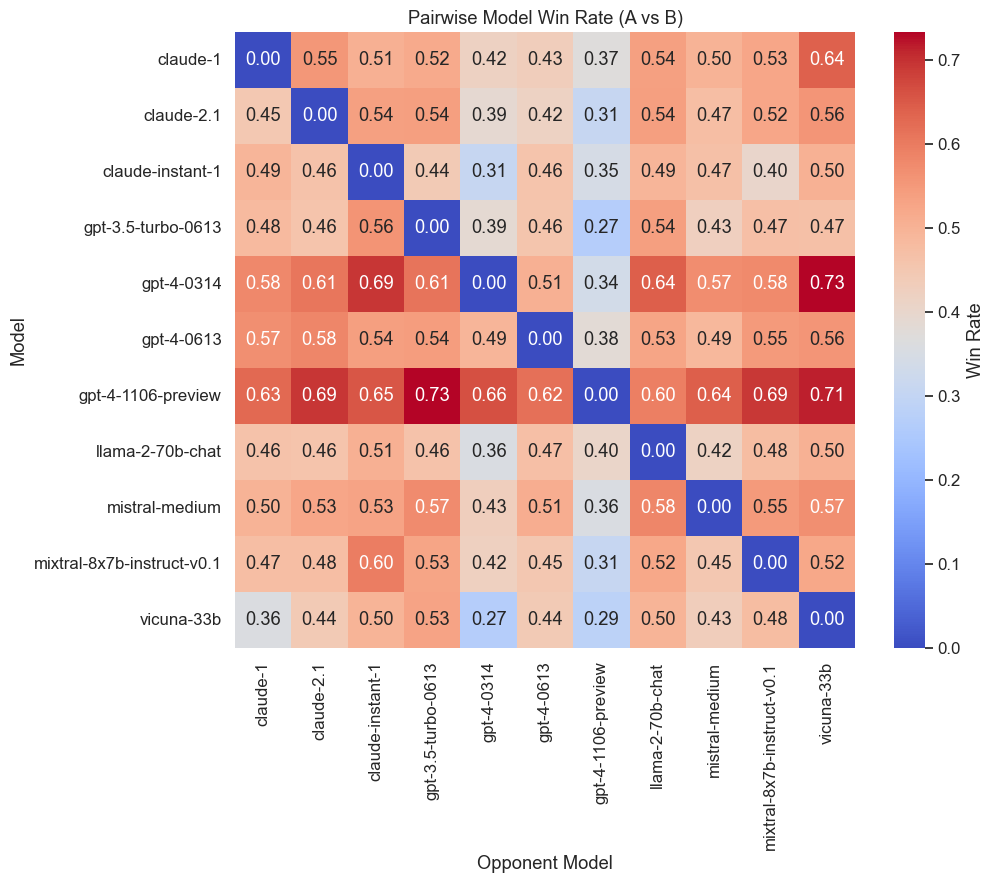

In [31]:
df = train_df.copy()

# 각 행에서 어떤 모델이 이겼는지 결정
def get_winner(row):
    if row['winner_model_a'] == 1:
        return row['model_a']
    elif row['winner_model_b'] == 1:
        return row['model_b']
    elif row['winner_tie'] == 1:
        return 'tie'
    else:
        return None

df['winner'] = df.apply(get_winner, axis=1)

# 주요 모델만 필터링 (빈도가 너무 낮은 모델은 제외)
model_list = (
    df['model_a'].value_counts()[:10].index.union(
        df['model_b'].value_counts()[:10].index
    ).unique()
)
df = df[df['model_a'].isin(model_list) & df['model_b'].isin(model_list)]

# 승률 계산용 매트릭스 초기화
models = sorted(model_list)
win_matrix = pd.DataFrame(0.0, index=models, columns=models)
count_matrix = pd.DataFrame(0, index=models, columns=models)

# 각 row마다 모델 간 승/패 기록
for _, row in df.iterrows():
    a, b, winner = row['model_a'], row['model_b'], row['winner']
    if winner == 'tie':
        win_matrix.loc[a, b] += 0.5
        win_matrix.loc[b, a] += 0.5
    elif winner == a:
        win_matrix.loc[a, b] += 1
    elif winner == b:
        win_matrix.loc[b, a] += 1
    count_matrix.loc[a, b] += 1
    count_matrix.loc[b, a] += 1

# 승률 계산 (이긴 횟수 / 총 매치 수)
win_rate = win_matrix / count_matrix
win_rate = win_rate.fillna(0)

# 시각화
plt.figure(figsize=(10,8))
sns.heatmap(win_rate, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Win Rate'})
plt.title("Pairwise Model Win Rate (A vs B)")
plt.xlabel("Opponent Model")
plt.ylabel("Model")
plt.show()

- GPT-4 계열이 전반적으로 0.6~0.7 win rate를 가져 거의 모든 모델을 상대로 우위
- Claude 계열이 GPT-4 상대로 약한 상황
- GPT-3.5-Turbo는 승률이 낮진 않으나 GPT-4, Claude 모델에게는 거의 패배
- Vicuna, Llama, Mistral, Mixtral은 거의 모든 상위 모델에 패한 상황